In [ ]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 73.3 MB/s eta 0:00:00


In [ ]:
# Import the Nilearn library
from nilearn import datasets
import nilearn.datasets
from nilearn.datasets import fetch_oasis_vbm
from nilearn.image import load_img
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


**Pre-processing**

In [ ]:
# Fetch the Oasis VBM dataset
oasis_data=nilearn.datasets.fetch_oasis_vbm(n_subjects=None, dartel_version=True)

[get_dataset_dir] Dataset found in /root/nilearn_data/oasis1

In [ ]:
# Load the DataFrame with clinical and demographic variables
ext_vars = pd.DataFrame(oasis_data['ext_vars'])

In [ ]:
# Load external variables
#ext_vars = oasis_data.ext_vars.copy()

# Set 'id' column as index
ext_vars = ext_vars.set_index('id')

# Drop 'hand' and 'delay' columns
# The 'hand' column is excluded because all subjects are right-handed, offering no variability or discriminatory power.
# The 'delay' column is removed as it consists entirely of Nans, providing no information for the analysis.
ext_vars = ext_vars.drop(columns=['hand', 'delay'], errors='ignore')

# Set all NaN values in 'cdr' to 0.0
ext_vars['cdr'] = ext_vars['cdr'].fillna(0.0)

# Impute 'mmse', 'ses', and 'educ' with their median values
median_imputer = SimpleImputer(strategy='median')
for col in ['mmse', 'ses', 'educ']:
    ext_vars[[col]] = median_imputer.fit_transform(ext_vars[[col]])

# Ensure 'etiv' is an integer after imputation
ext_vars['etiv'] = ext_vars['etiv'].astype(int)

# Encode the 'mf' column (sex: Male/Female) to numerical values
label_encoder = LabelEncoder()
ext_vars['mf'] = label_encoder.fit_transform(ext_vars['mf'])

# Convert 'cdr' into a binary variable (0.0 == 0, 0.5/1.0/2.0 == 1)
ext_vars['cdr'] = ext_vars['cdr'].apply(lambda x: 0 if x == 0.0 else 1).astype(int)

# Reset index after processing
ext_vars.reset_index(drop=True, inplace=True)

# Check results
print(ext_vars.dtypes)
print(ext_vars.head())

mf        int64
age       int64
educ    float64
ses     float64
mmse    float64
cdr       int64
etiv      int64
nwbv    float64
asf     float64
dtype: object
   mf  age  educ  ses  mmse  cdr  etiv   nwbv    asf
0   0   74   2.0  3.0  29.0    0  1344  0.743  1.306
1   0   55   4.0  1.0  29.0    0  1147  0.810  1.531
2   0   73   4.0  3.0  27.0    1  1454  0.708  1.207
3   1   28   3.0  2.0  29.0    0  1588  0.803  1.105
4   1   18   3.0  2.0  29.0    0  1737  0.848  1.010


Pre-Processing step for Random Forests

In [ ]:
# Process gray matter maps
nifti_masker = NiftiMasker(standardize=False, smoothing_fwhm=2, memory="nilearn_cache")
gm_maps_masked = nifti_masker.fit_transform(oasis_data.gray_matter_maps)

In [ ]:
# Feature selection: remove low-variance voxels
variance_threshold = VarianceThreshold(threshold=0.01)
gm_maps_masked_filtered = variance_threshold.fit_transform(gm_maps_masked)

In [ ]:
# Create voxel-level feature DataFrame
voxel_columns = [f"voxel_{i}" for i in range(gm_maps_masked_filtered.shape[1])]
X_df = pd.DataFrame(gm_maps_masked_filtered, columns=voxel_columns)

In [ ]:
# Combine clinical and voxel data
final_df = pd.concat([ext_vars.reset_index(drop=True), X_df.reset_index(drop=True)], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

# Data split and standardization

# Create a list with the features
clinical_features = ['mf', 'age', 'educ', 'ses', 'mmse', 'etiv', 'nwbv', 'asf']
all_features = clinical_features + voxel_columns

# Target
X = final_df[all_features]
y = final_df['cdr']

# Split into train+val and test (80/20 stratified)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split train+val into train and val (80/20 stratified)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

print("\nData splits:")
print(f"Train: {X_train.shape[0]} samples")
print(f"Val: {X_val.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")

# Define the preprocessor: scale clinical features, pass voxels unchanged
preprocessor = ColumnTransformer(transformers=[('clinical', StandardScaler(), clinical_features),('voxels', 'passthrough', voxel_columns)])

# Fit scaler on training data only and transform val, test
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)




Data splits:
Train: 257 samples
Val: 65 samples
Test: 81 samples


**Random Forests**

In [ ]:
pip install optuna

In [ ]:
import random
import tensorflow as tf
import numpy as np
import os
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS']= '1'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             precision_score, recall_score, f1_score,
                             roc_auc_score, log_loss, brier_score_loss,
                             confusion_matrix, classification_report)
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from optuna.visualization.matplotlib import plot_optimization_history

In [ ]:
from sklearn.metrics import (roc_curve, auc, precision_recall_curve)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Some of the RF hyperparameters are taken from this paper
# Aslan, E., & Özüpak, Y. (2025). Comparison of machine learning algorithms for automatic prediction of Alzheimer disease. Journal of the Chinese Medical Association, 88(2), 98-107.

In [ ]:
# Set random state and number of folds for StratifiedKFold
n_splits = 5
random_state = 42
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

In [ ]:
# Define the Optuna objective function
def Objective_rf(trial):
    # Define hyperparameters to tune
    max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    n_estimators = trial.suggest_int("n_estimators", 100, 700, step=50)
    max_features = trial.suggest_categorical("max_features", ['log2', 'sqrt'])
    criterion = trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss'])
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 14, step=2)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 14, step=2)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Define the classifier
    clf_rf = RandomForestClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        max_features=max_features,
        criterion=criterion,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        bootstrap=bootstrap,
        class_weight='balanced',
        random_state=random_state,
        n_jobs=-1)

    # Cross-validation with f1 scoring
    scores = cross_val_score(clf_rf, X_train, y_train, cv=stratified_kfold, scoring='f1')
    return scores.mean()


In [ ]:
# Run the Optuna optimization
study_rf = optuna.create_study(study_name='RF_hyperparameter_optimization', direction='maximize')
study_rf.optimize(Objective_rf, n_trials=30)

# Extract the best hyperparameters
best_rf_params = study_rf.best_params
print("\nBest Hyperparameters:", best_rf_params)



Best Hyperparameters: {'max_depth': 2, 'n_estimators': 150, 'max_features': 'log2', 'criterion': 'gini', 'min_samples_leaf': 14, 'min_samples_split': 8, 'bootstrap': False}


In [ ]:
import warnings
import optuna

# Suppress Optuna ExperimentalWarning
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=ExperimentalWarning)

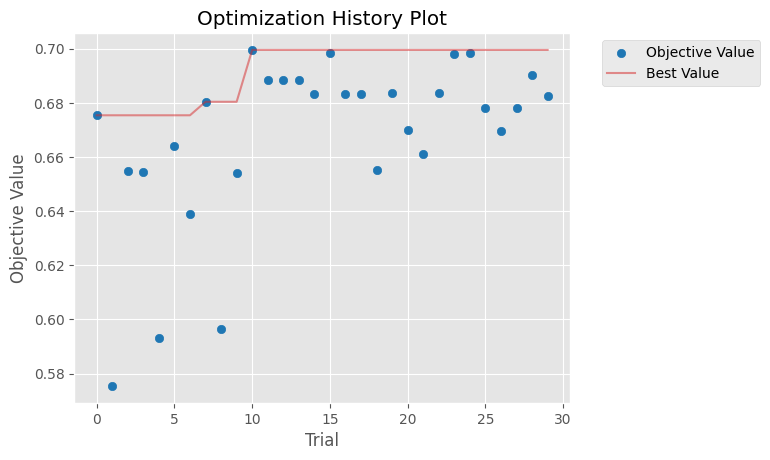

In [ ]:
#  Visualize optimization history
optuna.visualization.matplotlib.plot_optimization_history(study_rf)
plt.show()

In [ ]:
final_params_rf = dict(max_depth=best_rf_params['max_depth'], n_estimators = best_rf_params['n_estimators'],
                        max_features = best_rf_params['max_features'], criterion = best_rf_params['criterion'], min_samples_leaf = best_rf_params['min_samples_leaf'],
                        min_samples_split = best_rf_params['min_samples_split'], bootstrap = best_rf_params['bootstrap'])

In [ ]:
# Istantiate the classifier with the best hyperparameters found
clf_tuned_rf = RandomForestClassifier(**final_params_rf, class_weight='balanced', random_state=42, n_jobs=-1)


In [ ]:
# Fit the model
clf_tuned_rf.fit(X_trainval, y_trainval)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=2,
                       max_features='log2', min_samples_leaf=14,
                       min_samples_split=8, n_estimators=150, n_jobs=-1,
                       random_state=42)

In [ ]:
# Define the evaluate_model() function

def evaluate_model(y_true, y_pred, y_proba, class_names=None):
    if class_names is None:
        class_names = ['Non-Demented', 'Demented']

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)

    if y_proba.ndim > 1:
        y_proba = y_proba[:, 1]  # Keep only probabilities for class 1

    # Define the Evaluation Metrics
    accuracy = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    logloss = log_loss(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)

    # Print the output
    print("\n Binary Classification Evaluation")
    print(f"Accuracy:             {accuracy:.4f}")
    print(f"Balanced Accuracy:    {balanced_acc:.4f}")
    print(f"Precision:            {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1 Score:             {f1:.4f}")
    print(f"Log Loss:             {logloss:.4f}")
    print(f"Brier Score:          {brier:.4f}")
    print(f"AUC-ROC:              {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Create the figure to plot the Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Create the figure to plot the ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

FINAL RANDOM FOREST MODEL EVALUATION ON TEST SET

 Binary Classification Evaluation
Accuracy:             0.7654
Balanced Accuracy:    0.8285
Precision:            0.5000
Recall (Sensitivity): 0.9474
F1 Score:             0.6545
Log Loss:             0.5566
Brier Score:          0.1875
AUC-ROC:              0.8540

Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.98      0.71      0.82        62
    Demented       0.50      0.95      0.65        19

    accuracy                           0.77        81
   macro avg       0.74      0.83      0.74        81
weighted avg       0.87      0.77      0.78        81



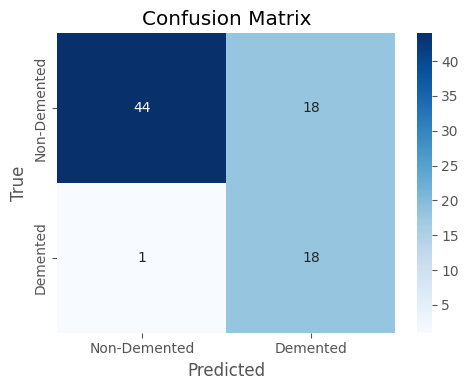

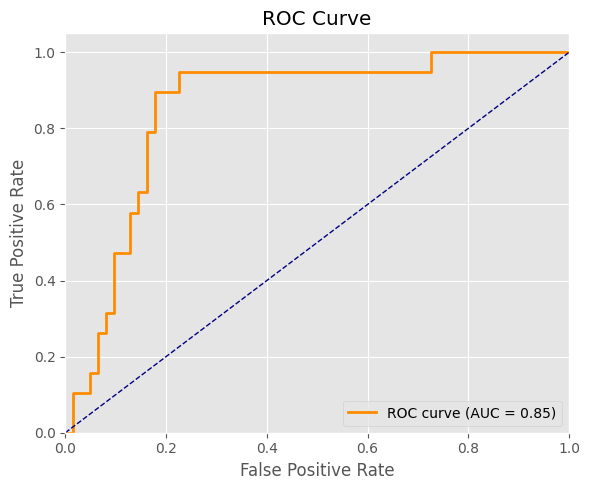

In [ ]:
# Make predictions on the Test Set
X_test = pd.DataFrame(X_test, columns=clf_tuned_rf.feature_names_in_)

y_test_pred = clf_tuned_rf.predict(X_test)  # Class labels (0/1)
y_test_proba = clf_tuned_rf.predict_proba(X_test)[:, 1]  # Prob for class 1 (Demented)

# Compute the metrics, plot the confusion matrix and the ROC curve
print("FINAL RANDOM FOREST MODEL EVALUATION ON TEST SET")

test_metrics = evaluate_model(
    y_true=y_test,
    y_pred=y_test_pred,
    y_proba=y_test_proba,
    class_names=['Non-Demented', 'Demented'])
plt.savefig("confusion_matrix_default_threshold.png", dpi=300)
plt.close()

EVALUATION WITH OPTIMAL THRESHOLD (0.5848)

 Binary Classification Evaluation
Accuracy:             0.8395
Balanced Accuracy:    0.8587
Precision:            0.6071
Recall (Sensitivity): 0.8947
F1 Score:             0.7234
Log Loss:             0.5566
Brier Score:          0.1875
AUC-ROC:              0.8540

Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.96      0.82      0.89        62
    Demented       0.61      0.89      0.72        19

    accuracy                           0.84        81
   macro avg       0.78      0.86      0.81        81
weighted avg       0.88      0.84      0.85        81



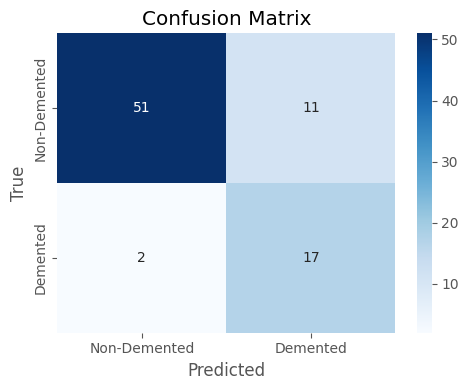

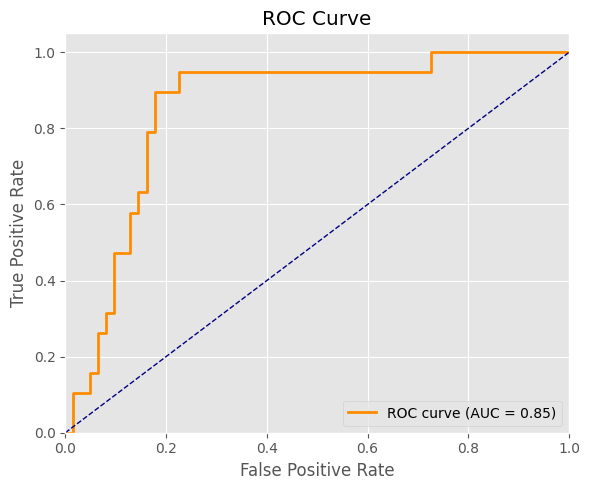

In [ ]:
# Compute the metrics, plot the confusion matrix with the optimal threshold based on F1 score, and the ROC curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"EVALUATION WITH OPTIMAL THRESHOLD ({optimal_threshold:.4f})")

y_test_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)

evaluate_model(
    y_true=y_test,
    y_pred=y_test_pred_optimal,
    y_proba=y_test_proba,
    class_names=['Non-Demented', 'Demented'])
plt.savefig("confusion_matrix_optimal_threshold.png", dpi=300)
plt.close()
